Setup an experiment with given data and arch by adjusting config

In [1]:
import os
import importlib
import neptune
import pandas as pd
import numpy as np
import datetime as dt
import torch
tnn = torch.nn
top = torch.optim

from torch.utils import data as tdt
from src import utils
%matplotlib inline

ARCHS_DIR = 'archs'
DATA_DIR = 'data'
EXPERIMENTS_DIR = 'experiments'
NEPTUNE_PRJ = 'indiacovidseva/covid-net'

### Device Info

In [2]:
CUDA="cuda:0"
CPU="cpu"
if torch.cuda.is_available():
    device = torch.device(CUDA)
    cd = torch.cuda.current_device()
    print("Num devices:", torch.cuda.device_count())
    print("Current device:", cd)
    print("Device name:", torch.cuda.get_device_name(cd))
    print("Device props:", torch.cuda.get_device_properties(cd))
#     print(torch.cuda.memory_summary(cd))
else:
    device = torch.device(CPU)
print(device)

Num devices: 1
Current device: 0
Device name: Tesla T4
Device props: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)
cuda:0


### Experiment Config

In [45]:
config = {
    "NEPTUNE_ID": "",
    "ID": "0027",
    "DESC": "Batch 1, weather data - thp",
    "ARCH": "v3",
    "DATASET": "ds_cdthp_pgba_4020_dataset_2020-09-15_v3.csv.pt",
    "IP_FEATURES": [0, 2, 3, 4],
    "OP_FEATURES": [0],
    "AUX_FEATURES": [],
    "BATCH_SIZE": 1,
    "HIDDEN_SIZE": 40,
    "NUM_LAYERS": 4,
    "DROPOUT": 0.5,
    "LEARNING_RATE": 0.001,
    "NUM_EPOCHS": 3001
}

NEPTUNE = True # toggle neptune

RESUME = False # retrain a previously trained model
resume_exp = EXPERIMENTS_DIR + "/" + "0001"
resume_cp = "latest-e" + "1740" + ".pt"
if RESUME:
    assert resume_exp and resume_cp

# setup exp
experiment_dir = EXPERIMENTS_DIR + '/' + config['ID']
try:
    os.mkdir(experiment_dir)
except OSError:
    print("!!WARNING!! EXPERIMENT ALREADY EXISTS:", config['ID'])
else:
    print("Initialising experiment:", config['ID'])
print("Resume:", RESUME, resume_exp, resume_cp)

# load data
ds = torch.load(DATA_DIR + "/" + config['DATASET'])
print("Dataset loaded")
config['DS'] = ds['config']
print(config['DS'])

# load arch
arch_mod = importlib.import_module("." + config['ARCH'], ARCHS_DIR)
importlib.reload(arch_mod) # ensure changes are imported

# init Net
model = arch_mod.CovidNet(
    ip_seq_len=config['DS']['IP_SEQ_LEN'], 
    op_seq_len=config['DS']['OP_SEQ_LEN'],
    ip_size=len(config['IP_FEATURES']),
    op_size=len(config['OP_FEATURES']),
    hidden_size=config['HIDDEN_SIZE'], 
    num_layers=config['NUM_LAYERS'],
    dropout=config['DROPOUT'],
    ip_aux_size=len(config['AUX_FEATURES']),
    device=device
)
model = model.to(device)
print ("Model initialised")
print("Num params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# init Loss and Optimizer
loss_fn = tnn.L1Loss()
optimizer = top.Adam(model.parameters(), lr=config['LEARNING_RATE'])

# init dataset loaders
trn_loader = tdt.DataLoader(ds['trn'], shuffle=True, batch_size=config['BATCH_SIZE'])
val_loader = tdt.DataLoader(ds['val'], shuffle=True, batch_size=config['BATCH_SIZE'])

Initialising experiment: 0027
Resume: False experiments/0001 latest-e1740.pt
Dataset loaded
{'FEATURES': ['new_cases', 'new_deaths', 'temp_mean', 'humidity_mean', 'pressure_mean'], 'POP_FEATURES': ['new_cases', 'new_deaths'], 'AUX_FEATURES': ['population_density', 'gdp_per_capita', 'hospital_beds_per_thousand', 'median_age'], 'VAL_RATIO': 0.3, 'IP_SEQ_LEN': 40, 'OP_SEQ_LEN': 20, 'SRC': 'dataset_2020-09-15_v3.csv'}
Model initialised
Num params: 78740


### Training loop

In [ ]:
trn_loss_vals = []
val_loss_vals = []
trn_acc_vals = []
val_acc_vals = []
e = 0
min_val_loss = np.Inf
max_val_acc = 0

if RESUME:
    cp = utils.load_checkpoint(resume_exp, resume_cp, device=device)
    old_config, md, od = cp['config'], cp['model_state_dict'], cp['optimizer_state_dict']
    model.load_state_dict(md)
    optimizer.load_state_dict(od)
#     e = cp['epoch'] + 1
#     trn_loss_vals, val_loss_vals, min_val_loss = cp['trn_losses'], cp['val_losses'], cp['min_val_loss']
#     trn_acc_vals, val_acc_vals, max_val_acc = cp['trn_acc'], cp['val_acc'], cp['max_val_acc']
    try:
        assert config['IP_FEATURES'] == old_config['IP_FEATURES']
        assert config['OP_FEATURES'] == old_config['OP_FEATURES']
        assert config['HIDDEN_SIZE'] == old_config['HIDDEN_SIZE']
        assert config['DS']['IP_SEQ_LEN'] == old_config['DS']['IP_SEQ_LEN']
        assert config['DS']['OP_SEQ_LEN'] == old_config['DS']['OP_SEQ_LEN']
        assert config['AUX_FEATURES'] == old_config.get('AUX_FEATURES', [])
    except:
        import traceback as tb
        print("Failed to resume.")
        print("Old config:", old_config)
        print("New config:", config)
        tb.print_exc()

if NEPTUNE:
    neptune_prj = neptune.init(NEPTUNE_PRJ)
    if config['NEPTUNE_ID']:
        neptune_exp = neptune_prj.get_experiments(id=config['NEPTUNE_ID'])[0]
    else:
        neptune_exp = neptune.create_experiment(name=config['ID'], params=config)
        config['NEPTUNE_ID'] = neptune_exp.id

# TRAIN
print("BEGIN: [", dt.datetime.now(), "]")
while e < config['NUM_EPOCHS']:
    model.train()
    trn_losses = []
    trn_ops = []
    for data in trn_loader:
        ip, ip_aux, op = data
#         print("ip all", ip)
        ip = ip[:, :, config['IP_FEATURES']].to(device)
#         print("ip model", ip)
        ip_aux = ip_aux[:, config['AUX_FEATURES']].to(device).view(-1, len(config['AUX_FEATURES'])) if len(config['AUX_FEATURES']) else None
        op = op[:, :, config['OP_FEATURES']].to(device)
        optimizer.zero_grad() # set grads to 0
        preds = model(
            ip.view(-1, config['DS']['IP_SEQ_LEN'], len(config['IP_FEATURES'])),
            aux_ip=ip_aux
        ) # predict
#         print("preds", preds)
        loss = loss_fn(preds, op.view(-1, config['DS']['OP_SEQ_LEN'], len(config['OP_FEATURES']))) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights
        trn_losses.append(loss) # logging
        trn_ops.append(op.mean())
    avg_trn_loss = torch.stack(trn_losses).mean().item()
    avg_trn_acc = 1 - avg_trn_loss / torch.stack(trn_ops).mean().item()
    trn_loss_vals.append(avg_trn_loss * 10000)
    trn_acc_vals.append(avg_trn_acc * 100)
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        val_ops = []
        for data in val_loader:
            ip, ip_aux, op = data
            ip = ip[:, :, config['IP_FEATURES']].to(device)
            ip_aux = ip_aux[:, config['AUX_FEATURES']].to(device).view(-1, len(config['AUX_FEATURES'])) if len(config['AUX_FEATURES']) else None
            op = op[:, :, config['OP_FEATURES']].to(device)
            preds = model(
                ip.view(-1, config['DS']['IP_SEQ_LEN'], len(config['IP_FEATURES'])),
                aux_ip=ip_aux
            )
            loss = loss_fn(preds, op.view(-1, config['DS']['OP_SEQ_LEN'], len(config['OP_FEATURES'])))
            val_losses.append(loss)
            val_ops.append(op.mean())
        avg_val_loss = torch.stack(val_losses).mean().item()
        avg_val_acc = 1 - avg_val_loss / torch.stack(val_ops).mean().item()
        val_loss_vals.append(avg_val_loss * 10000)
        val_acc_vals.append(avg_val_acc * 100)
    
    if NEPTUNE:
        neptune_exp.log_metric('validation accuracy', avg_val_acc*100)
        neptune_exp.log_metric('training accuracy', avg_trn_acc*100)
        neptune_exp.log_metric('validation loss', avg_val_loss*1e4)
        neptune_exp.log_metric('training loss', avg_trn_loss*1e4)
    
    if e%1==0:
        print(
            "[", dt.datetime.now(), "] epoch:", f"{e:5}", 
            "val_acc:", f"{avg_val_acc*100: 4.2f}", "trn_acc:", f"{avg_trn_acc*100: 4.2f}", 
            "val_loss:", f"{avg_val_loss*1e4: 4.2f}", "trn_loss:", f"{avg_trn_loss*1e4: 4.2f}"
        )
    if e%1==0:
        utils.save_checkpoint(
            config, e, model, optimizer, 
            trn_loss_vals, val_loss_vals, min_val_loss,
            trn_acc_vals, val_acc_vals, max_val_acc,
            experiment_dir, "/latest-e" + str(e) + ".pt"
        )
        if avg_val_acc >= max_val_acc:
            max_val_acc = avg_val_acc
#             utils.save_checkpoint(
#                 config, e, model, optimizer, 
#                 trn_loss_vals, val_loss_vals, min_val_loss,
#                 trn_acc_vals, val_acc_vals, max_val_acc,
#                 experiment_dir, "/best-e" + str(e) + ".pt"
#             )
    e+=1
print("END: [", dt.datetime.now(), "]")

if NEPTUNE:
    neptune_exp.stop()

https://ui.neptune.ai/indiacovidseva/covid-net/e/COV-26
BEGIN: [ 2020-09-19 19:23:25.654384 ]
[ 2020-09-19 19:25:26.228830 ] epoch:     0 val_acc:  49.04 trn_acc:  6.71 val_loss:  179.13 trn_loss:  325.97
Checkpoint saved
[ 2020-09-19 19:27:24.652095 ] epoch:     1 val_acc:  64.20 trn_acc:  56.46 val_loss:  125.84 trn_loss:  152.12
Checkpoint saved
[ 2020-09-19 19:29:22.330978 ] epoch:     2 val_acc:  71.57 trn_acc:  63.17 val_loss:  99.93 trn_loss:  128.67
Checkpoint saved
[ 2020-09-19 19:31:19.385050 ] epoch:     3 val_acc:  67.04 trn_acc:  65.51 val_loss:  115.85 trn_loss:  120.50
Checkpoint saved
[ 2020-09-19 19:33:15.819401 ] epoch:     4 val_acc:  69.95 trn_acc:  66.54 val_loss:  105.63 trn_loss:  116.91
Checkpoint saved
[ 2020-09-19 19:35:12.288819 ] epoch:     5 val_acc:  71.68 trn_acc:  68.18 val_loss:  99.54 trn_loss:  111.18
Checkpoint saved
[ 2020-09-19 19:37:08.125848 ] epoch:     6 val_acc:  72.32 trn_acc:  68.53 val_loss:  97.30 trn_loss:  109.96
Checkpoint saved
[ 2020-

Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-20 11:29:40.779608 ] epoch:   502 val_acc:  72.99 trn_acc:  71.38 val_loss:  94.94 trn_loss:  100.00
Checkpoint saved
[ 2020-09-20 11:31:35.518113 ] epoch:   503 val_acc:  70.88 trn_acc:  70.22 val_loss:  102.37 trn_loss:  104.03
Checkpoint saved
[ 2020-09-20 11:33:30.423497 ] epoch:   504 val_acc:  71.27 trn_acc:  69.42 val_loss:  101.00 trn_loss:  106.85
Checkpoint saved
[ 2020-09-20 11:35:25.179780 ] epoch:   505 val_acc:  70.97 trn_acc:  69.71 val_loss:  102.02 trn_loss:  105.83
Checkpoint saved
[ 2020-09-20 11:37:20.058256 ] epoch:   506 val_acc:  70.98 trn_acc:  69.77 val_loss:  102.01 trn_loss:  105.63
Checkpoint saved


Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-20 11:39:14.552275 ] epoch:   507 val_acc:  69.02 trn_acc:  69.80 val_loss:  108.89 trn_loss:  105.52
Checkpoint saved


Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-20 11:41:09.159648 ] epoch:   508 val_acc:  59.45 trn_acc:  67.01 val_loss:  142.51 trn_loss:  115.27
Checkpoint saved
[ 2020-09-20 11:43:04.160759 ] epoch:   509 val_acc:  65.52 trn_acc:  63.17 val_loss:  121.18 trn_loss:  128.69
Checkpoint saved
[ 2020-09-20 11:44:59.412341 ] epoch:   510 val_acc:  62.79 trn_acc:  66.61 val_loss:  130.80 trn_loss:  116.66
Checkpoint saved
[ 2020-09-20 11:46:54.581605 ] epoch:   511 val_acc:  67.44 trn_acc:  62.27 val_loss:  114.45 trn_loss:  131.81
Checkpoint saved
[ 2020-09-20 11:48:49.552333 ] epoch:   512 val_acc:  67.14 trn_acc:  64.15 val_loss:  115.50 trn_loss:  125.27
Checkpoint saved
[ 2020-09-20 11:50:44.561257 ] epoch:   513 val_acc:  64.88 trn_acc:  63.83 val_loss:  123.46 trn_loss:  126.38
Checkpoint saved
[ 2020-09-20 11:52:39.322573 ] epoch:   514 val_acc:  68.27 trn_acc:  66.19 val_loss:  111.52 trn_loss:  118.14
Checkpoint saved
[ 2020-09-20 11:54:33.988612 ] epoch:   515 val_acc:  68.17 trn_acc:  66.75 val_loss:  111.89 trn

Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-20 12:27:04.680752 ] epoch:   532 val_acc:  53.10 trn_acc:  52.08 val_loss:  164.83 trn_loss:  167.43
Checkpoint saved
[ 2020-09-20 12:28:59.658330 ] epoch:   533 val_acc:  54.33 trn_acc:  52.92 val_loss:  160.51 trn_loss:  164.49
Checkpoint saved
[ 2020-09-20 12:30:54.627831 ] epoch:   534 val_acc:  55.04 trn_acc:  53.76 val_loss:  158.04 trn_loss:  161.56
Checkpoint saved
[ 2020-09-20 12:32:49.076264 ] epoch:   535 val_acc:  54.40 trn_acc:  54.21 val_loss:  160.29 trn_loss:  159.99
Checkpoint saved
[ 2020-09-20 12:34:44.091588 ] epoch:   536 val_acc:  55.12 trn_acc:  53.18 val_loss:  157.74 trn_loss:  163.57
Checkpoint saved
[ 2020-09-20 12:36:38.641620 ] epoch:   537 val_acc:  56.84 trn_acc:  55.28 val_loss:  151.69 trn_loss:  156.26
Checkpoint saved
[ 2020-09-20 12:38:33.437169 ] epoch:   538 val_acc:  62.60 trn_acc:  60.27 val_loss:  131.44 trn_loss:  138.80
Checkpoint saved
[ 2020-09-20 12:40:28.476898 ] epoch:   539 val_acc:  63.44 trn_acc:  60.87 val_loss:  128.51 trn

Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-20 13:15:08.890906 ] epoch:   557 val_acc:  66.72 trn_acc:  65.44 val_loss:  116.98 trn_loss:  120.75
Checkpoint saved
[ 2020-09-20 13:17:05.544481 ] epoch:   558 val_acc:  61.01 trn_acc:  62.32 val_loss:  137.06 trn_loss:  131.66
Checkpoint saved
[ 2020-09-20 13:19:02.040662 ] epoch:   559 val_acc:  56.07 trn_acc:  62.45 val_loss:  154.42 trn_loss:  131.19
Checkpoint saved
[ 2020-09-20 13:20:58.083815 ] epoch:   560 val_acc:  61.64 trn_acc:  59.04 val_loss:  134.82 trn_loss:  143.13
Checkpoint saved
[ 2020-09-20 13:22:53.808977 ] epoch:   561 val_acc:  59.61 trn_acc:  62.35 val_loss:  141.97 trn_loss:  131.54
Checkpoint saved
[ 2020-09-20 13:24:49.675301 ] epoch:   562 val_acc:  59.27 trn_acc:  59.72 val_loss:  143.14 trn_loss:  140.75
Checkpoint saved


Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-20 13:26:45.572771 ] epoch:   563 val_acc:  59.22 trn_acc:  59.90 val_loss:  143.35 trn_loss:  140.12
Checkpoint saved
[ 2020-09-20 13:28:40.925752 ] epoch:   564 val_acc:  59.76 trn_acc:  58.71 val_loss:  141.43 trn_loss:  144.27
Checkpoint saved
[ 2020-09-20 13:30:36.605242 ] epoch:   565 val_acc:  60.45 trn_acc:  59.98 val_loss:  139.01 trn_loss:  139.82
Checkpoint saved
[ 2020-09-20 13:32:32.164931 ] epoch:   566 val_acc:  59.86 trn_acc:  58.80 val_loss:  141.08 trn_loss:  143.95
Checkpoint saved
[ 2020-09-20 13:34:27.668895 ] epoch:   567 val_acc:  60.57 trn_acc:  59.13 val_loss:  138.58 trn_loss:  142.78
Checkpoint saved
[ 2020-09-20 13:36:23.278939 ] epoch:   568 val_acc:  61.99 trn_acc:  60.07 val_loss:  133.59 trn_loss:  139.53
Checkpoint saved
[ 2020-09-20 13:38:18.857256 ] epoch:   569 val_acc:  63.71 trn_acc:  61.27 val_loss:  127.54 trn_loss:  135.31
Checkpoint saved
[ 2020-09-20 13:40:14.731878 ] epoch:   570 val_acc:  62.43 trn_acc:  63.25 val_loss:  132.05 trn

Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-21 15:38:47.345717 ] epoch:  1379 val_acc: -1.55 trn_acc: -9.16 val_loss:  356.93 trn_loss:  381.39
Checkpoint saved


Experiencing connection interruptions. Reestablishing communication with Neptune.
Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-21 15:40:42.433347 ] epoch:  1380 val_acc: -2.49 trn_acc: -5.72 val_loss:  360.23 trn_loss:  369.40
Checkpoint saved
[ 2020-09-21 15:42:37.638690 ] epoch:  1381 val_acc: -3.03 trn_acc: -4.30 val_loss:  362.14 trn_loss:  364.41
Checkpoint saved
[ 2020-09-21 15:44:32.698919 ] epoch:  1382 val_acc: -1.71 trn_acc: -3.88 val_loss:  357.50 trn_loss:  362.96
Checkpoint saved
[ 2020-09-21 15:46:28.503104 ] epoch:  1383 val_acc:  5.17 trn_acc: -9.19 val_loss:  333.32 trn_loss:  381.52
Checkpoint saved
[ 2020-09-21 15:48:23.377889 ] epoch:  1384 val_acc: -1.32 trn_acc: -3.21 val_loss:  356.14 trn_loss:  360.61
Checkpoint saved
[ 2020-09-21 15:50:18.976520 ] epoch:  1385 val_acc: -12.39 trn_acc: -11.49 val_loss:  395.03 trn_loss:  389.53
Checkpoint saved
[ 2020-09-21 15:52:13.969960 ] epoch:  1386 val_acc: -2.37 trn_acc: -12.51 val_loss:  359.83 trn_loss:  393.11
Checkpoint saved
[ 2020-09-21 15:54:08.874787 ] epoch:  1387 val_acc: -6.80 trn_acc: -10.55 val_loss:  375.39 trn_loss:  386.

Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-21 16:21:01.256052 ] epoch:  1401 val_acc:  43.95 trn_acc:  45.78 val_loss:  197.02 trn_loss:  189.45
Checkpoint saved
[ 2020-09-21 16:22:56.572980 ] epoch:  1402 val_acc:  48.02 trn_acc:  45.31 val_loss:  182.70 trn_loss:  191.08
Checkpoint saved
[ 2020-09-21 16:24:51.723790 ] epoch:  1403 val_acc:  44.78 trn_acc:  47.59 val_loss:  194.09 trn_loss:  183.11
Checkpoint saved
[ 2020-09-21 16:26:46.883285 ] epoch:  1404 val_acc:  55.20 trn_acc:  49.73 val_loss:  157.48 trn_loss:  175.66
Checkpoint saved
[ 2020-09-21 16:28:42.130771 ] epoch:  1405 val_acc:  54.82 trn_acc:  53.80 val_loss:  158.80 trn_loss:  161.41
Checkpoint saved
[ 2020-09-21 16:30:37.418784 ] epoch:  1406 val_acc:  50.09 trn_acc:  51.14 val_loss:  175.44 trn_loss:  170.72
Checkpoint saved
[ 2020-09-21 16:32:33.544098 ] epoch:  1407 val_acc:  53.31 trn_acc:  52.03 val_loss:  164.12 trn_loss:  167.60
Checkpoint saved
[ 2020-09-21 16:34:29.436283 ] epoch:  1408 val_acc:  58.64 trn_acc:  53.98 val_loss:  145.39 trn

Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-21 19:03:58.781210 ] epoch:  1472 val_acc:  73.15 trn_acc:  70.55 val_loss:  94.36 trn_loss:  102.88
Checkpoint saved
[ 2020-09-21 19:06:45.526924 ] epoch:  1473 val_acc:  71.48 trn_acc:  71.00 val_loss:  100.26 trn_loss:  101.33
Checkpoint saved
[ 2020-09-21 19:09:31.520894 ] epoch:  1474 val_acc:  71.93 trn_acc:  70.59 val_loss:  98.65 trn_loss:  102.76
Checkpoint saved
[ 2020-09-21 19:12:19.015090 ] epoch:  1475 val_acc:  72.66 trn_acc:  70.96 val_loss:  96.11 trn_loss:  101.46
Checkpoint saved
[ 2020-09-21 19:15:04.726561 ] epoch:  1476 val_acc:  72.71 trn_acc:  71.36 val_loss:  95.91 trn_loss:  100.07
Checkpoint saved


Experiencing connection interruptions. Reestablishing communication with Neptune.


[ 2020-09-21 19:17:50.737004 ] epoch:  1477 val_acc:  70.79 trn_acc:  71.07 val_loss:  102.67 trn_loss:  101.09
Checkpoint saved
[ 2020-09-21 19:20:37.941433 ] epoch:  1478 val_acc:  73.63 trn_acc:  71.23 val_loss:  92.70 trn_loss:  100.50
Checkpoint saved
[ 2020-09-21 19:23:26.797397 ] epoch:  1479 val_acc:  72.00 trn_acc:  71.16 val_loss:  98.40 trn_loss:  100.77
Checkpoint saved
[ 2020-09-21 19:26:15.503732 ] epoch:  1480 val_acc:  73.63 trn_acc:  71.16 val_loss:  92.68 trn_loss:  100.77
Checkpoint saved
[ 2020-09-21 19:29:04.088361 ] epoch:  1481 val_acc:  72.58 trn_acc:  71.45 val_loss:  96.37 trn_loss:  99.76
Checkpoint saved
[ 2020-09-21 19:31:52.463537 ] epoch:  1482 val_acc:  73.96 trn_acc:  71.64 val_loss:  91.52 trn_loss:  99.08
Checkpoint saved
[ 2020-09-21 19:34:42.362876 ] epoch:  1483 val_acc:  73.06 trn_acc:  71.85 val_loss:  94.69 trn_loss:  98.36
Checkpoint saved
[ 2020-09-21 19:37:31.795816 ] epoch:  1484 val_acc:  73.00 trn_acc:  71.75 val_loss:  94.90 trn_loss:  98

### Plot loss & acc

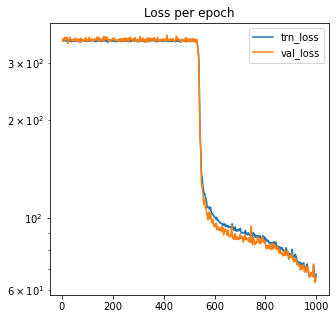

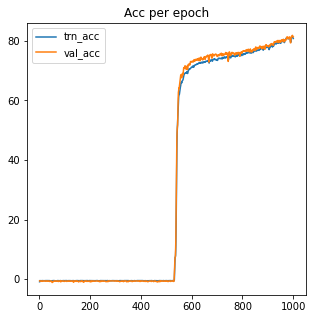

In [42]:
df_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals,
    'val_loss': val_loss_vals
})

df_acc = pd.DataFrame({
    'trn_acc': trn_acc_vals,
    'val_acc': val_acc_vals
})

# smoothen
df_loss['trn_loss'] = df_loss['trn_loss'].rolling(3, min_periods=1, center=True).mean()
df_loss['val_loss'] = df_loss['val_loss'].rolling(3, min_periods=1, center=True).mean()
df_acc['trn_acc'] = df_acc['trn_acc'].rolling(3, min_periods=1, center=True).mean()
df_acc['val_acc'] = df_acc['val_acc'].rolling(3, min_periods=1, center=True).mean()

_ = df_loss[2:].plot(
    y=['trn_loss', 'val_loss'],
    title='Loss per epoch',
    subplots=False,
    figsize=(5,5),
    sharex=False,
    logy=True
)
_ = df_acc[2:].plot(
    y=['trn_acc', 'val_acc'],
    title='Acc per epoch',
    subplots=False,
    figsize=(5,5),
    sharex=False,
    logy=False
)